<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - Neural Network <br>
<font color=696880 size=4>
    Alireza Belal
    
    
____


### Full Name : 
### Student Number : 
___

# Setup

# 0. Preparation

In this part, you will use a dataset related to COVID-19. Load your dataset using pandas.

In [74]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

covid_data = pd.read_csv('./Covid Dataset.csv')
categorical_feature_mask = covid_data.dtypes == object
cateforical_cols = covid_data.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
covid_data[cateforical_cols] = covid_data[cateforical_cols].apply(lambda col: le.fit_transform(col))
covid_data = covid_data.astype(float)

# Extract X and Y from the dataset
X_total = covid_data.iloc[:, 0:20].values
y_total = covid_data.iloc[:,20].values


#SPLIT THE DATA INTO TRAIN AND TEST DATA 
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.3, random_state = 0)
train = TensorDataset(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train)))
train_loader = DataLoader(train, batch_size = 32, shuffle = True)
test = TensorDataset(torch.Tensor(np.array(X_test)), torch.Tensor(np.array(y_test)))
test_loader = DataLoader(train, batch_size = 32, shuffle = True)

In [75]:
X_train.shape

(3803, 20)

---------------

# 1. DNN as nonlinear dimensionality reduction method (50 Points)

Autoencoder is an unsupervised artificial neural network that compresses the data to lower dimension and then reconstructs the input back. Autoencoder finds the representation of the data in a lower dimension by focusing more on the important features getting rid of noise and redundancy. It's based on Encoder-Decoder architecture, where encoder encodes the high-dimensional data to lower-dimension and decoder takes the lower-dimensional data and tries to reconstruct the original high-dimensional data.

![picture](https://drive.google.com/uc?id=1RTZwx4xL6zFV_nUENBgWlFKLKldPoyI-)

In the above Diagram, X is the input data, z is the lower-dimension representation of input X and X’ is the reconstructed input data. The mapping of higher to lower dimensions can be linear or non-linear depending on the choice of the activation function.

In this part you're gonna implement an autoencoder using Keras framework as dimensionally reduction module as explained [here](https://blog.keras.io/building-autoencoders-in-keras.html).
(It would be ok to use PyTorch as well.)
Reduce the dimension of the data to 2 dimensions and visualize the low-dimensional data.

In [76]:
import torch
from torch import nn

In [77]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20, 10),
            # nn.ReLU(),
            # nn.Linear(10, 4),
            # nn.ReLU(),
            nn.Linear(10, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            # nn.ReLU(),
            # nn.Linear(4, 8),
            # nn.ReLU(),
            nn.Linear(10, 20)
            )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [78]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [79]:
import copy

total_step = len(train_loader)
num_epochs = 100
train_loss, validation_loss = [], []

best_result = 0.0
best_net = None

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader: 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(images)

    avg_loss = running_loss / len(train)
    train_loss.append(avg_loss)
    model.eval()
    
    with torch.no_grad():
        loss_val = 0.0
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            loss_val += loss.item()  * len(images)
        avg_loss_val = loss_val / len(test)
        validation_loss.append(avg_loss_val)
    if avg_loss_val > best_result:
        best_result = avg_loss_val
        best_net = copy.deepcopy(model)
    model.train()
    print('[epoch %d] Train Loss: %.4f Validation Loss: %.4f' % (
        epoch + 1, avg_loss, avg_loss_val))

[epoch 1] Train Loss: 0.2620 Validation Loss: 0.4809
[epoch 2] Train Loss: 0.2041 Validation Loss: 0.4706
[epoch 3] Train Loss: 0.2000 Validation Loss: 0.4616
[epoch 4] Train Loss: 0.1962 Validation Loss: 0.4528
[epoch 5] Train Loss: 0.1923 Validation Loss: 0.4431
[epoch 6] Train Loss: 0.1883 Validation Loss: 0.4347
[epoch 7] Train Loss: 0.1853 Validation Loss: 0.4296
[epoch 8] Train Loss: 0.1837 Validation Loss: 0.4266
[epoch 9] Train Loss: 0.1825 Validation Loss: 0.4243
[epoch 10] Train Loss: 0.1815 Validation Loss: 0.4219
[epoch 11] Train Loss: 0.1806 Validation Loss: 0.4198
[epoch 12] Train Loss: 0.1797 Validation Loss: 0.4175
[epoch 13] Train Loss: 0.1788 Validation Loss: 0.4154
[epoch 14] Train Loss: 0.1778 Validation Loss: 0.4134
[epoch 15] Train Loss: 0.1769 Validation Loss: 0.4114
[epoch 16] Train Loss: 0.1762 Validation Loss: 0.4096
[epoch 17] Train Loss: 0.1753 Validation Loss: 0.4079
[epoch 18] Train Loss: 0.1747 Validation Loss: 0.4062
[epoch 19] Train Loss: 0.1740 Validat

In [80]:
encoded_data = []
for images, labels in test_loader:
    encoded = model.encoder(images)
    for e, l in zip(encoded.detach().numpy(), labels.numpy()):
        encoded_data.append((e,l))

In [81]:
print(encoded_data)

[(array([0.3026157 , 0.29828525], dtype=float32), 0.0), (array([-1.1354802 ,  0.46436906], dtype=float32), 1.0), (array([-1.3661861 , -0.01751488], dtype=float32), 1.0), (array([-1.096931  ,  0.07905459], dtype=float32), 1.0), (array([-0.6584421,  0.7136073], dtype=float32), 1.0), (array([-0.69389695,  1.3010181 ], dtype=float32), 1.0), (array([-1.0821395,  0.3565026], dtype=float32), 1.0), (array([-0.28972948,  0.24644893], dtype=float32), 1.0), (array([-0.88268846, -0.5266173 ], dtype=float32), 1.0), (array([-0.82276016,  0.50326705], dtype=float32), 1.0), (array([0.427457  , 0.23923957], dtype=float32), 0.0), (array([-0.26527268,  0.56761825], dtype=float32), 1.0), (array([ 0.7055131 , -0.21191509], dtype=float32), 0.0), (array([-0.24012077,  0.3161342 ], dtype=float32), 1.0), (array([-0.28996503,  0.70423186], dtype=float32), 1.0), (array([-0.150778  ,  0.46360195], dtype=float32), 1.0), (array([-0.62809175,  0.7535168 ], dtype=float32), 1.0), (array([-0.31605494, -0.1082806 ], dty

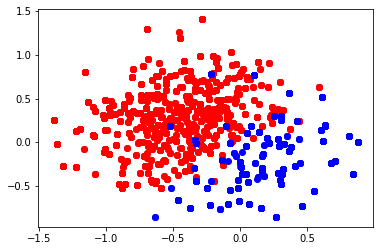

In [82]:
from matplotlib import pyplot as plt
x = np.array([t[0][0] for t in encoded_data])
y = np.array([t[0][1] for t in encoded_data])
color = np.array([int(t[1]) for t in encoded_data])
plt.scatter(x[color == 1],y[color == 1], color = 'red')
plt.scatter(x[color == 0],y[color == 0], color = 'blue')
plt.show()